# Informe Tarea 2 Grupo 2
## Nombre Alumnos: Ignacio Brito, José Tomás De la Peña, Ítalo Salazar, Alex Villarroel

## P1 - Programación del Problema Directo
Se provee de una carpeta ajuste_ortogonal_recta que deberá copiar en la carpeta del paquete de python
desarrollado en la Tarea 1, es decir al interior de GF7013/models/. En este módulo se encuentra la definición
de la recta paramétrica y el prototipo de una clase forward que permitirá calcular el modelo directo.
En un intento por generalizar los códigos de muestreo que se utilizan posteriormente, se definirá un requerimiento
que debe cumplir la clase forward (que implementa el modelo directo para cualquier problema y no sólo para el
ajuste ortogonal a la recta): que un objeto que sea instancia de la clase forward debe implementar la función
miembro eval(m) donde m es el vector de parámetros del modelo.
Para el problema del ajuste ortogonal de la linea recta, se tiene m = [a, θ]⊤, donde a es la distancia de la recta
al origen y θ define la orientación de la recta en sentido anti-horario con respecto al eje x (ver apunte que define
el problema de ajuste ortogonal a la recta).
Luego se pide:

### P1.1 Completar la función eval(self, m) de la manera más concisa posible. Para ello utilice el paquete recta que se provee.
-----------------------------------------------------------------------------------------------
La función eval se calculó calcula la predicción de los parámetros del modelo, es decir, dados los valores de las observaciones (incluyendo los sigmas), y los parámetros de modelo, en este caso a y el ángulo $\theta$, retorne los valores de la estimación del problema directo

Este método se implementó de la siguiente manera:

```python
class forward(object):
# 
# definición de la clase ...
# método eval
    def eval(self, m):
        """
        Computes a prediction of the model parameters (see description in this
        module docstring).
        - m = np.array([a, theta]) with theta in degrees (both float quantities). 
          -> a is the distance between straight line to origin of coordinate system and 
          -> theta is the orientation of the straight line measured counter-clockwise 
            measured from x axis. 
        """
        # Extract model parameters
        a, theta = m[0], m[1]

        # calculate the predicted points in the straight line
        dpred = recta.calc_xy_pred(a, theta, self.x_obs, self.y_obs)

        # dpred incluyendo el cálculo de los sigma

        return dpred


In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

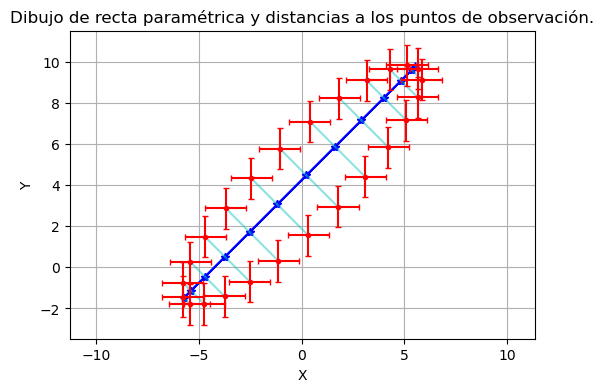

In [2]:
### P1.2 - Ejemplo de modelo directo


from GF7013.models.ajuste_ortogonal_recta.forward import forward
import numpy as np
from GF7013.bin.Tarea2.P1.datos import obtener_datos_elipses
from GF7013.models.ajuste_ortogonal_recta import recta
N = 25
semi_eje_mayor = 8
semi_eje_menor = 2
alpha = 45
delta_x = 0
delta_y = 4
desviacion_estandar_x = 1.0
desviacion_estandar_y = 1.0
# valores de d
x_obs, y_obs, sigma_x, sigma_y = obtener_datos_elipses(
                                        N = N,
                                        a = semi_eje_mayor,
                                        b = semi_eje_menor,
                                        alpha = alpha,
                                        deltax = delta_x,
                                        deltay = delta_y,
                                        sigma_x = desviacion_estandar_x,
                                        sigma_y = desviacion_estandar_y)
# valores de m 
a = 3
theta = 45 # grados sexagesimales despues de hacer P1.1)
# se define m como un array
m = np.array([a, theta]) # modelo de recta a graficar.

directo = forward(x_obs=x_obs, y_obs=y_obs, sigma_x=sigma_x, sigma_y=sigma_y)
# le calculamos las predicciones de la recta
# s es el vector con la proyeccion ortogonal de cada punto en la recta.
# s = np.array([np.array([x_obs[i], y_obs[i]]).dot(t) for i in range(0, len(x_obs))])
x_pred, y_pred, s = directo.dpred(m)

# plotear los resultados
import matplotlib.pyplot as plt
fig = plt.figure(1)
fig.clear()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
# en el comando siguiente, si el color es 'none' no se grafica el elemento.
# recta.plot_recta(ax, *m, x_obs=x_obs, y_obs=y_obs, color_dist='c', color='b')
ax.plot(x_pred, y_pred, 'b-*', label='Recta paramétrica')
ax.plot([x_pred, x_obs],
        [y_pred, y_obs],
        linestyle = '-', 
        color = 'c', 
        alpha = alpha/100)
ax.errorbar(x=x_obs, y=y_obs, xerr=sigma_x, yerr=sigma_y, fmt='.r', capsize=2)
ax.axis('equal')
ax.grid('on')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Dibujo de recta paramétrica y distancias a los puntos de observación.')
fig.canvas.draw()
plt.show()

##  P2. Modelación Inversa usando Métodos Bayesianos: A priori's y función  $f_{prior}(m)$

### P2.1. Densidad volumétrica a priori para los parámetros del modelo fprior(m)
Para la densidad volumétrica a priori de los parámetros del modelo fprior(m), se asumirá el estado homogéneo de información. Para ello, se considera que los parámetros del modelo son ambos parámetros cartesianos, por lo que la fdp a priori para m será la de una distribución uniforme.


Se debe definir un rango de valores posibles para el parámetro a que sea lo suficientemente grande, por ejemplo, ±2 veces el máximo de las normas de $d^{obs}_k$ (que son los datos observados a ajustar con la recta, o los datos sintéticos a usar en esta tarea).

Además, se define el rango de posibles valores de θ en el intervalo $[−180, 180[$ grados sexagesimales.

En la Tarea 1, en GF7013/probability_functions/pdf/pdf_uniform_nD.py programaron una
clase pdf_uniform_nD, que permite calcular la verosimilitud (i.e., sin normalizar) - y su logaritmo natural - de una distribución uniforme de n dimensiones.

En la carpeta Tarea2/tests escriba un script test_fprior.py que cree una instancia de pdf_-
uniform_nD que represente fprior (m) para el caso del problema del ajuste a la recta y genere 1E5 muestras de fprior(m). Graficar el histograma conjunto de (a, θ) – use matplotlib.pyplot.hist2d – y los histogramas marginales para cada uno de los dos parámetros. Recuerde escoger bien el número o tamaño de casilleros del histograma para que luzca como una distribución uniforme.

----------------------------------Resolución -------------------------------------------------------

Para la resolución del problema, en la función test_fprior se definió la función histogram_p2_1 que realiza el histograma 2d solicitado con sus respectivos histogramas marginales para cada parámetro. 

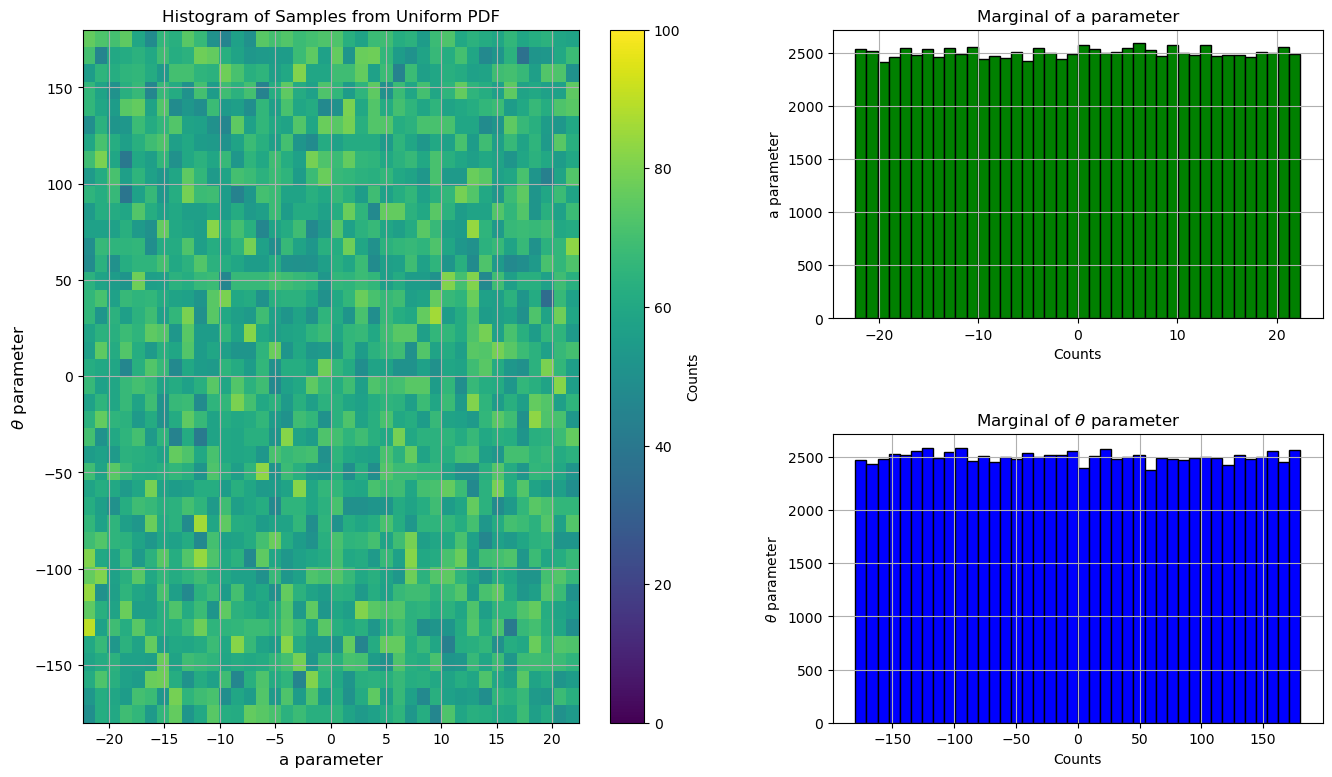

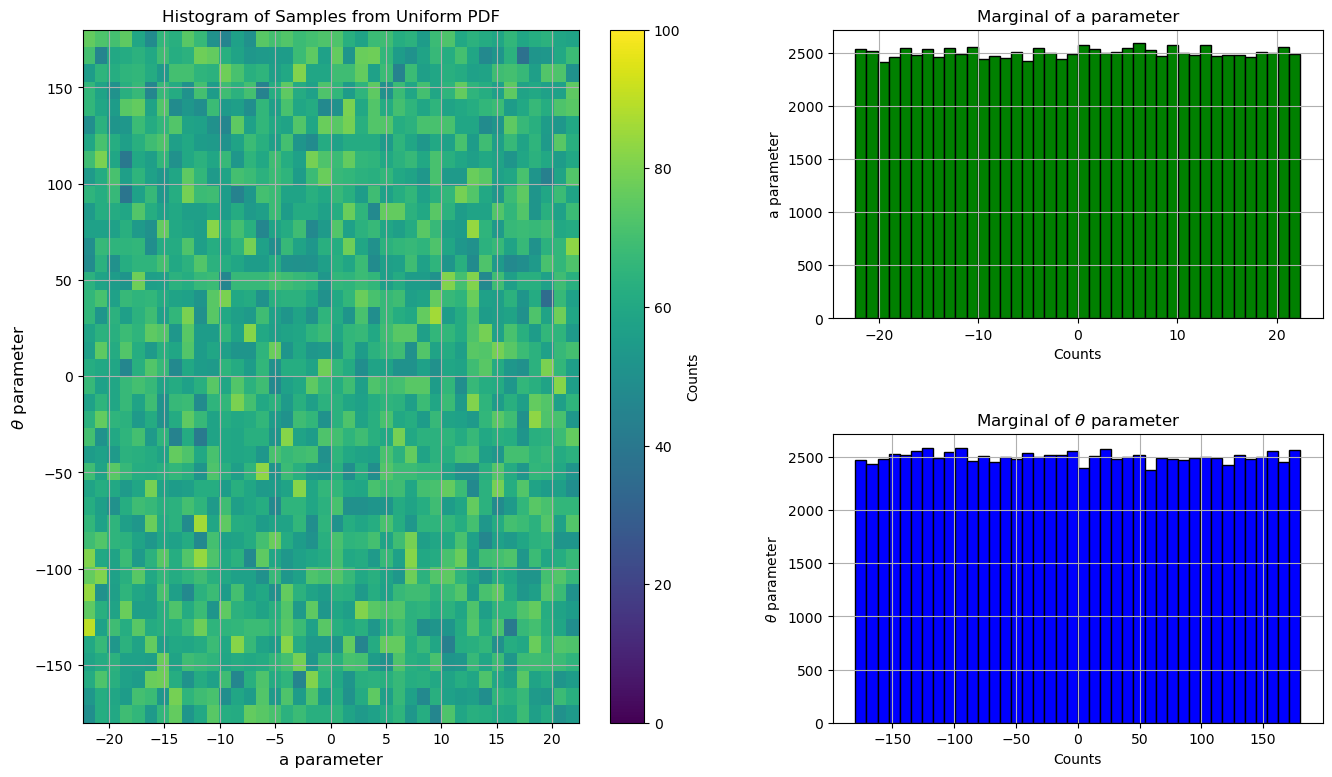

In [3]:
from GF7013.probability_functions.pdf import pdf_uniform_nD
norm_dobs = np.sqrt((x_obs**2+y_obs**2))
#
ll_a, ul_a = -2*np.max(norm_dobs), 2* np.max(norm_dobs)
ll_theta, ul_theta = -180,180 
#
lower_lim = np.array([ll_a,ll_theta])
upper_lim = np.array([ul_a,ul_theta])
par = {'lower_lim': lower_lim,'upper_lim':upper_lim}
pdf_uniforme = pdf_uniform_nD(par)
#
N_samples = int(1e5)
#
LogOfZero = None
rng = np.random.default_rng(42)  # Para reproducibilidad
f_prior = pdf_uniform_nD(par, LogOfZero=LogOfZero, rng=rng) 
samples = f_prior._draw(N_samples)
# Ahora llamamos a la función para plotear que se creó en test_fprior.py
# podríamos agregarla a utils
import GF7013.bin.Tarea2.tests.test_fprior as test_fprior
fig = test_fprior.histogram_p2_1(samples,0,100);
plt.show();


### P2.2 Función de Verosimilitud $\mathcal{L}(m)$

Para poder definir la función de verosimilitud de un modelo $\mathcal{L}(m)$ primero se definirá la distribución a priori
para la variable de interés. En este caso, como se desea hacer un ajuste ortogonal de una recta, se quiere encontrar
modelos que minimicen la distancia a los datos. Luego, la variable sobre la cual se debe definir información a priori
corresponde a la distancias $\Delta_k$ entre los pares ordenados observados y la recta (ver archivo pdf adjunto con la tarea y explicado por el profesor auxiliar).

En esta tarea se asume que los errores de dichas distancias son independientes y que siguen una distribución normal. Como se quiere que dichas distancias sean lo más pequeñas posibles, se propone utilizar una distribución
normal, con media nula y varianzas $\sigma^2_{\Delta_k}$ con fdp:

$$ \rho_\Delta(\mathbf{\Delta,\sigma^2_{\Delta_k}}) =  \nu e ^{-\frac{1}{2}\sum_{k=1}^N \frac{\Delta^2_k}{\sigma^2_{\Delta_k}}}  $$

Donde $\nu$ es una constante de normalización.

Luego, si para un modelo $\mathbf{m}$ dado, se calcula las distancias $\mathbf{\Delta(m)}$ y la bariaza de dichas distancias $\mathbf{\sigma^2_\Delta(m)}$, la verosimilitud de dicho modelo se puede calcular como:

$$𝓛(\mathbf{m}) = \rho_\Delta(\mathbf{\Delta(m),\sigma^2_{\Delta}(m)}) $$

La función de verosimilitud se encuentra programada en GF7013/probability_functions/likelihood_function.py. Esta recibe una instancia de modelo directo (forward) y una instancia de la fdp a priori de los datos (pdf_data). Se recomienda leer el código de la función de verosimilitud antes de proseguir con el desarrollo
de la tarea.

## P2.2.1 Verificación de la programación de $\rho_\Delta$

La función de probabilidad a priori para las observaciones se asumirá como una distribución Normal Multivariada. En la Tarea 1, se programó la clase pdf_normal.py en el módulo GF7013/probability_functions/pdf_normal.py. En esta parte de la tarea debe cerciorarse de que dicha clase funcione, y es una oportunidad para arreglar cualquier error que haya tenido en el desarrollo de la Tarea 1.

Para verificar su programación de pdf_normal.py, cree un script en el módulo Tarea2/tests/test_pdf_normal.py que genera 100.000 muestras de una distribución normal multivariada con media mu = np.array([-1, 4]) y matriz de covarianza cov = np.array([[2, 1], [1, 4]]) y que luego verifique que el promedio y matriz de covarianza calculados con las muestras sea similar a mu y cov anteriores, respectivamente.

Además, se pide hacer un histograma 2D de las muestras de la fdp conjunta y hacer histogramas de las 2 fdp marginales.

Sample Mean: [-1.00312805  3.99973846]
Sample Covariance:
 [[1.99495575 0.99220652]
 [0.99220652 4.0409389 ]]


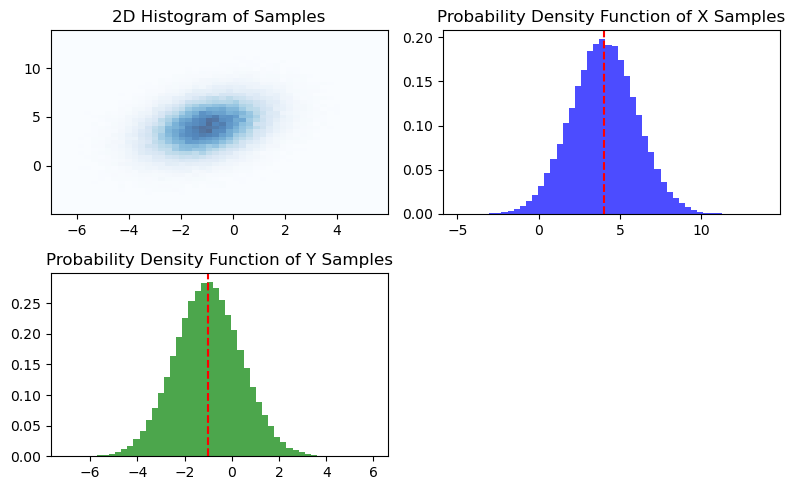

In [4]:
from GF7013.probability_functions.pdf import pdf_normal

N_samples = 1e5
mu = np.array([-1, 4])
cov = np.array([[2, 1], [1, 4]])
rng = np.random.default_rng(42)  # Para reproducibilidad
par = {'mu': mu, 'cov': cov}

f_prior = pdf_normal(par, rng=rng)
samples = f_prior._draw(N_samples)

# Verificar covarianza y media de las muestras
sample_mean = np.mean(samples, axis=1)
sample_cov = np.cov(samples)
print("Sample Mean:", sample_mean)
print("Sample Covariance:\n", sample_cov)

# Graficar las muestras
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax[0, 0].hist2d(samples[0], samples[1], bins=50, density=True, cmap='Blues', alpha=0.7)
ax[0, 0].set_title('2D Histogram of Samples')
ax[0, 1].hist(samples[1], bins=50, density=True, alpha=0.7, color='blue')
ax[0, 1].axvline(mu[1], color='red', linestyle='--', label='Mean')
ax[0, 1].set_title('Probability Density Function of X Samples')
ax[1, 0].hist(samples[0], bins=50, density=True, alpha=0.7, color='green')
ax[1, 0].axvline(mu[0], color='red', linestyle='--', label='Mean')
ax[1, 0].set_title('Probability Density Function of Y Samples')
fig.delaxes(ax[1, 1])
plt.tight_layout()
plt.show()

### P2.2.2. Verificación de la programación de L(m)
Para verificar la programación de L(m), se utilizará el método de Grid-Search para resolver el problema inverso (ver apuntes del curso GF5013), esto se puede hacer ya que solo hay dos parámetros involucrados. Para ello, use los datos sintéticos que se proveen en GF7013/bin/Tarea2/P1/P1b.py y cree un script en el módulo
Tarea2/tests/test_Likelihood.py.
En dicho script,

1. Defina un conjunto de valores de a y θ (use np.linspace) que cubran el rango de valores con probabilidad
no nula de $f_{prior}(m)$. Luego, cree un conjunto de modelos m con todas las combinaciones posibles de a y
θ.
2. Cree una instancia de la clase ensemble, que se encuentra definida en GF7013/model_parameters/
ensemble.py, guarde ahí el conjunto de modelos y llene las variables fprior, like, y f con las verosimilitudes
correspondientes a cada uno de esos modelos (i.e., use la función likelihood de los objetos definidos para
$f_{prior}(m)$  y $\mathcal{L}(m)$)
3. Cree otra instancia de la clase ensemble, que se encuentra definida en GF7013/model_parameters/
ensemble.py, guarde ahí el conjunto de modelos y llene las variables fprior, like, y f con el logaritmo
natural de las verosimilitudes correspondientes a cada uno de esos modelos (i.e., use la función log_likelihood de los objetos definidos para $f_{prior}(m)$  y $\mathcal{L}(m)$)

4. Haga un gráfico 2D con colores (puede usar matplotlib.pyplot.pcolor o matplotlib.pyplot.scatter, en el segundo teniendo cuidado con el tamaño de los símbolos) para los valores de verosimilitud fprior, like, y f; y del logaritmo natural de la verosimilitud fprior, like, y f (son 6 gráficos de colores en total)

#### Resolución
1. Definir todas las combinaciones de valores de a y de $\theta$ es posible realizando un mallado 2d con np.meshgrid(), y luego uniendo ambos parametros aplanando cada componente del mallado. Los limites de a fueron definidos en el enunciado como $\pm 2 \cdot max(|d_{k}^{obs}|)$, mientra que $\theta$ de -180 a 180 grados hexadecimales



Text(0, 0.5, '$\\theta$ values')

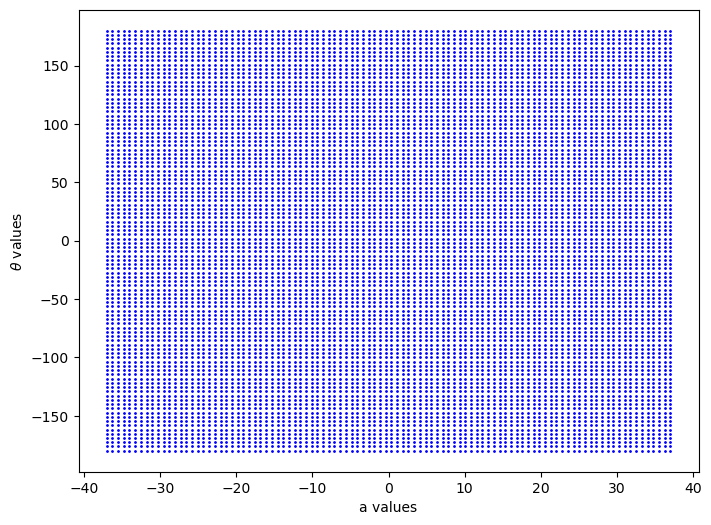

In [5]:
from GF7013.bin.Tarea2.P1.datos import obtener_datos_elipses
from GF7013.model_parameters.ensemble import ensemble
from GF7013.probability_functions.pdf import pdf_uniform_nD,pdf_normal
from GF7013.probability_functions.likelihood.likelihood_function import likelihood_function
from GF7013.models.ajuste_ortogonal_recta.forward import forward
from GF7013.models.ajuste_ortogonal_recta.recta import calc_dist_sigma
# Generar datos sinteticos
N = int(70)
semi_eje_mayor = 10
semi_eje_menor = 2
alpha = -45
delta_x = 0
delta_y = -10
desviacion_estandar_x = 1.0
desviacion_estandar_y = 0.5

x_obs, y_obs, sigma_x, sigma_y = obtener_datos_elipses(
                                        N = N,
                                        a = semi_eje_mayor,
                                        b = semi_eje_menor,
                                        alpha = alpha,
                                        deltax = delta_x,
                                        deltay = delta_y,
                                        sigma_x = desviacion_estandar_x,
                                        sigma_y = desviacion_estandar_y)

# definición de los parámetros
norm_dobs = np.sqrt((x_obs**2+y_obs**2))
#
ll_a, ul_a = -2*np.max(norm_dobs), 2* np.max(norm_dobs)
ll_theta, ul_theta = -180,180 
#
lower_lim = np.array([ll_a,ll_theta])
upper_lim = np.array([ul_a,ul_theta])

# Valores de la grilla

theta_values = np.linspace(ll_theta, ul_theta, 100)
a_values = np.linspace(ll_a, ul_a, 100)

Nmodels = len(theta_values) * len(a_values)
Npar=2

a_grid,theta_grid = np.meshgrid(a_values,theta_values)
m_values=grid = np.stack([a_grid.ravel(), theta_grid.ravel()], axis=1)
# plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(a_grid, theta_grid, s=1, color='blue')
ax.set_xlabel('a values')
ax.set_ylabel(r'$\theta$ values')

2. Una vez definidos los m posibles, se procede a establecer a priori como la fdp uniforme con los parámetros de limite inferior y superior establecidos anteriormente, utilizando una semilla para su reproductibilidad. Posterior a ello, se invoca una instancia de forward con los datos sintéticos. El likelihood se realiza a partir de lo establecido en el enunciado, con media nula y varianza $\sigma^2_{\Delta_k}$

In [6]:
par = {'lower_lim': lower_lim, 'upper_lim': upper_lim}
LogOfZero = None
rng_uni = np.random.default_rng(66)
f_prior = pdf_uniform_nD(par=par, LogOfZero=LogOfZero, rng=rng_uni)

# Forward model
forward_model = forward(x_obs, y_obs, sigma_x, sigma_y)

# Likelihood function
LogOfZero = None
rng = np.random.default_rng(777)

likelihood=np.zeros(Nmodels)
likelihood_f_prior=np.zeros(Nmodels)
likelihood_f_posterior= np.zeros(Nmodels)

# Log likelihood
loglikelihood = np.zeros(Nmodels)
loglikelihood_f_prior = np.zeros(Nmodels)
loglikelihood_f_posterior = np.zeros(Nmodels)

mu = np.zeros(N)
cov = np.eye(N)

par = {'mu': mu, 'cov': cov}
likelihood_func = likelihood_function(forward=forward_model, pdf_data=pdf_normal(par=par, rng=rng))

for i, model in enumerate(m_values):
    likelihood_f_prior[i] = f_prior._likelihood(model)
    likelihood[i] = likelihood_func.likelihood(model)
    likelihood_f_posterior[i] = likelihood_f_prior[i] * likelihood[i]
    
    # Log likelihood
    loglikelihood_f_prior[i] = f_prior._log_likelihood(model)
    loglikelihood[i] = likelihood_func.log_likelihood(model)
    loglikelihood_f_posterior[i] = loglikelihood_f_prior[i] + loglikelihood[i]

# Create ensemble objects
ensamble = ensemble(Npar = Npar, Nmodels = Nmodels, use_log_likelihood=False)

ensamble.fprior = likelihood_f_prior
ensamble.like = likelihood
ensamble.f = likelihood_f_posterior

ensamble_log = ensemble(Npar=Npar,Nmodels=Nmodels,use_log_likelihood=True)

ensamble_log.fprior = loglikelihood_f_prior
ensamble_log.like = loglikelihood
ensamble_log.f = loglikelihood_f_posterior

Floating point overflow when calculating the normalization constant.
Use log_pdf or (log) Likelihood values instead of pdf.


3. El loglikelihood está incluído en el código anterior, solamente se generó un ensamble distinto con las características del loglikelihood
4. El mallado generado con anterioridad nos sirve para hacer los plots con pcolormesh

6


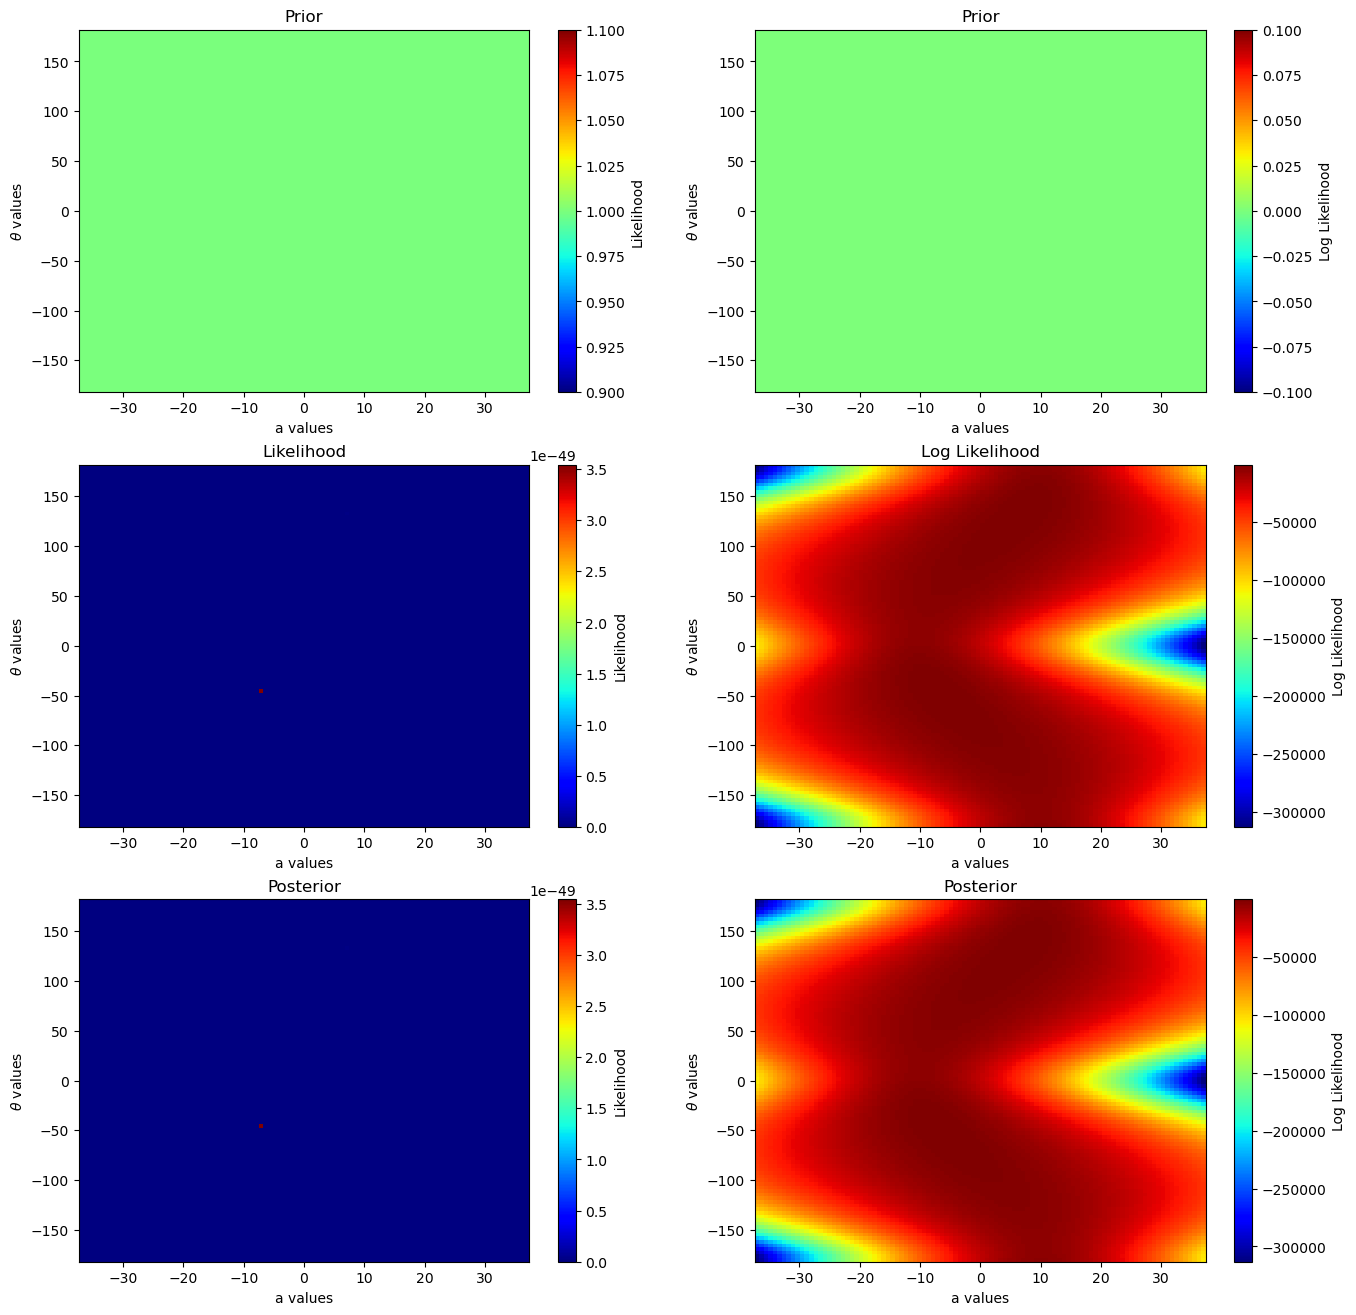

In [7]:
# plot with pcolormesh, using a_grid,theta_grid
fig,axs = plt.subplots(3,2, figsize=(16, 16))
axs = axs.flatten()
lists = [ensamble.fprior, ensamble_log.fprior,
         ensamble.like, ensamble_log.like,
         ensamble.f, ensamble_log.f]
cbarlabels = ['Likelihood','Log Likelihood','Likelihood', 'Log Likelihood','Likelihood', 'Log Likelihood']
print(len(cbarlabels))
for i, data in enumerate(lists):
    pcm = axs[i].pcolormesh(a_grid, theta_grid, data.reshape(a_grid.shape), shading='auto', cmap='jet')
    fig.colorbar(pcm, ax=axs[i], label=cbarlabels[i])
    axs[i].set_xlabel('a values')
    axs[i].set_ylabel(r'$\theta$ values')
    axs[i].set_title(['Prior','Prior','Likelihood','Log Likelihood','Posterior','Posterior'][i])

# P3. Resolución del problema inverso: Programación del Algoritmo de Metrópolis
En esta etapa de la tarea se programará y verificará el algoritmo de Metrópolis. Antes de proseguir se recomienda leer el encabezado (docstring) del código del algoritmo de Metropolis en GF7013/sampling/metropolis/metropolis.py

## P3.1. Programación del algoritmo

### P3.1.1. Distribución de Proposición

En esta sección se completó la clase `proposal_normal`, ubicada en `GF7013/sampling/metropolis/proposal_normal.py`. Esta clase implementa una distribución de proposición normal multivariada, utilizada para generar modelos candidatos a partir del modelo actual de la cadena de Markov.

La construcción se basa en generar **perturbaciones** aleatorias $\delta m$ desde una distribución gaussiana con media cero y matriz de covarianza $\Sigma$:

$$
\delta m \sim \mathcal{N}(0, \Sigma)
$$

Luego, el modelo propuesto se obtiene como:

$$
m_{\text{test}} = m + \delta m
$$

luego la razón de aceptación del algoritmo es:

$$
r = \frac{f_{\text{post}}(m_{\text{test}})}{f_{\text{post}}(m)}
$$

y se decide si se acepta o no el nuevo modelo evaluando $\min(1, r)$ y comparándolo con un número aleatorio $u \sim \mathcal{U}(0,1)$.

Para verificar el correcto funcionamiento de la clase, se implementó un test en `Tarea2/tests/test_proposal_normal.py`, en el que se generaron $10^6$ propuestas a partir de un modelo inicial $m_0 = [0, 0]$, utilizando una matriz de covarianza $\Sigma = \text{diag}(7, 4)$. La covarianza empírica de los modelos propuestos fue muy similar a la esperada, validando la implementación.

Finalmente, se graficaron las propuestas en un espacio 3D. En este gráfico:

- El eje $x$ muestra la variación del primer parámetro del modelo (a).
- El eje $y$ muestra la variación del segundo parámetro ($\theta$).
- El eje $z$ y la barra de color (`Model Proposal Order`) representan el orden temporal en que fueron generadas las propuestas, permitiendo observar cómo evoluciona la exploración del espacio de modelos a lo largo de las iteraciones, notando que se mantiene la distribución de los datos.




Covarianza de la distribución de proposición:
[[6.99861404 0.00785463]
 [0.00785463 3.99694841]]


<Figure size 800x600 with 0 Axes>

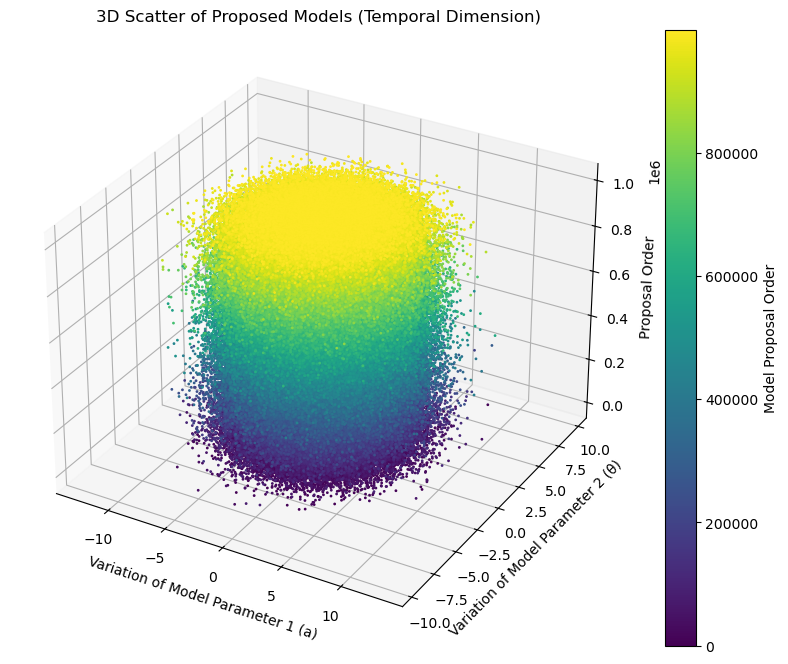

In [ ]:
from GF7013.sampling.metropolis.proposal_normal import proposal_normal
from mpl_toolkits.mplot3d import Axes3D  
# Número de modelos propuestos
N_models = 1e6

# Matriz de covarianza de la distribución de proposición
cov = np.array([[7, 0], [0, 4]])

rng = np.random.default_rng(42)  # Para reproducibilidad
m_0 = np.array([0, 0])  # Modelo inicial
proposal = proposal_normal(cov=cov)

models = np.zeros((2, int(N_models)))
for i in range(int(N_models)):
    # Generar un modelo aleatorio
    models[:, i] = proposal.propose(m_0)

# Covarianza de la distribución de proposición
cov_mod = np.cov(models)
# Imprimir la covarianza
print("Covarianza de la distribución de proposición:")
print(cov_mod)

# Graficar los modelos propuestos
plt.figure(figsize=(8, 6))
# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Crear scatter 3D
N_models = models.shape[1]
scatter = ax.scatter(models[0, :], models[1, :], np.arange(N_models), 
                     c=np.arange(N_models), cmap='viridis', s=1, alpha=1)
ax.set_title('3D Scatter of Proposed Models (Temporal Dimension)')
ax.set_xlabel('Variation of Model Parameter 1 (a)')
ax.set_ylabel('Variation of Model Parameter 2 (θ)')
ax.set_zlabel('Proposal Order')
fig.colorbar(scatter, ax=ax, label='Model Proposal Order')
plt.show()

### P3.1.2. Algoritmo de Metrópolis

Para esta parte se completó la implementación del algoritmo de Metrópolis en el módulo `GF7013/sampling/metropolis/metropolis.py`. Esta implementación permite recorrer el espacio de modelos mediante una cadena de Markov, aceptando o rechazando propuestas basadas en la razón de verosimilitud entre el modelo actual y el propuesto.

Se consideraron ambos enfoques para la evaluación de verosimilitud:
1. **En escala normal**: utilizando directamente la función de verosimilitud $\mathcal{L}(m)$ y la densidad a priori $f_{\text{prior}}(m)$.
2. **En escala logarítmica**: utilizando $\log(\mathcal{L}(m))$ y $\log(f_{\text{prior}}(m))$, lo cual permite mayor estabilidad numérica, especialmente cuando los valores de verosimilitud son muy pequeños.

Durante la ejecución, el algoritmo sigue los siguientes pasos:

- Se inicializa con un modelo $m_0$.
- En cada iteración, se genera un modelo de prueba $m_{\text{test}}$ a partir del modelo actual usando la distribución de propuesta (`proposal_normal`) cuyo funcionamiento fue explicado en la pregunta anterior.


El código fue probado en el script `Tarea2/tests/test_metropolis.py`, donde se utilizó una función de verosimilitud bimodal compuesta por la suma de dos distribuciones con distinto centro: una normal y otra tipo Laplace, con diferente dispersión y forma. El modelo inicial se fijó en $m_0 = -10$ y la distribución a priori fue uniforme en un intervalo amplio que cubre ambas modas.

Los resultados muestran que el algoritmo logra muestrear una de las modas, pero tiene dificultades para explorar ambas regiones de manera consistente, especialmente al repetir el experimento con diferentes semillas aleatorias. Esto es esperable en cadenas de Metrópolis cuando las modas están muy separadas y la propuesta es poco dispersa.

Para mejorar la exploración, se podrían ajustar parámetros como el número de muestras, la varianza de la propuesta, o utilizar métodos de remuestreo.



[-3.87284292 -3.92209896 -3.36707523 ... 13.1197618  13.1197618
 12.94987537]
[0.15760351 0.1549146  0.18157926 ... 0.33087006 0.33087006 0.27917513]


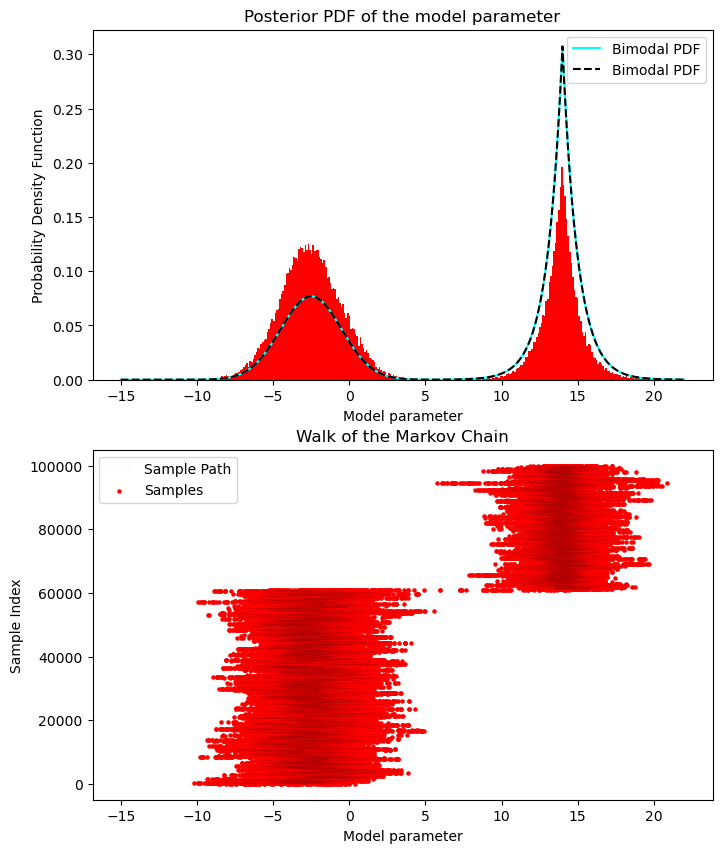

In [11]:
from GF7013.sampling.metropolis import metropolis
class pdf_bimodal(object):
    def __init__(self,  x_0, sigma_0, p_0, x_1, sigma_1, p_1):
        self.args_f0 = (x_0, sigma_0, p_0)
        self.args_f1 = (x_1, sigma_1, p_1)

    def __f(self, x, mean, sigma, p):
        alpha = 1 / sigma / np.sqrt(2*np.pi)
        return alpha * np.exp(-0.5*(np.sum(np.abs((x - mean)/sigma)**p)))

    def likelihood(self, x):
        return self.__f(x, *self.args_f0) + self.__f(x, *self.args_f1)
    
    def log_likelihood(self, x):
        return np.log(self.likelihood(x))


### MAIN CODE OF THE EXAMPLE.
NumBins = 100
# define the fdp to sample using SIR resampling
x_0 = -2.5
sigma_0 = 2.0
p_0 = 2

x_1 = 14 #9 #7.5
sigma_1 = 0.5#0.1 #0.75
p_1 = 1

# crear instancia de la pdf que usará como funcion de verosimilitud
f = pdf_bimodal(x_0, sigma_0, p_0, x_1, sigma_1, p_1)

# evaluate the pdf for later plot
x_min = -15
x_max = 22
Num_x = 10000
x_eval = np.linspace(x_min, x_max, Num_x)
f_values = np.array([f.likelihood(aux) for aux in x_eval])
dx = x_eval[1] - x_eval[0]
f_area = np.sum(f_values)*dx # rectangle integration

# define prior distribution
x_min_ini = -12
x_max_ini = 22
prior_pdf_pars = {}
prior_pdf_pars['lower_lim'] = np.array([x_min_ini])
prior_pdf_pars['upper_lim'] = np.array([x_max_ini])
fprior = pdf_uniform_nD(par=prior_pdf_pars)

# define proposal distribution
sigma_prop = (x_max_ini - x_min_ini)/100
proposal_params = {}
proposal_params['cov'] = np.array([[sigma_prop]]) # 2D array!!
proposal_pdf = proposal_normal(proposal_params['cov'])

# define initial model:
m0 = np.array([-10]) # 1D array!!!

# define initial models as samples from U(x_min, x_max)
NumSamples = int(1E5)
NumBurnIn = int(0.1 * NumSamples)
use_log_likelihood = False
#############
# YOU CAN TRY DIFFERENT VALUES OF BETA and see what happens!
beta = 1
#############
results = metropolis(m0= m0, 
                        likelihood_fun = f, 
                        pdf_prior = fprior, 
                        proposal = proposal_pdf, 
                        num_samples = NumSamples,
                        num_burnin = NumBurnIn,
                        use_log_likelihood = use_log_likelihood,
                        save_samples = True,
                        beta = beta)

print(results['samples'].m_set.flatten())
print(results['samples'].f)

f_values_beta = np.array([f.likelihood(aux)**beta for aux in x_eval])
dx = x_eval[1] - x_eval[0]
f_area_beta = np.sum(f_values_beta)*dx # rectangle integration
fig = plt.figure(1)
fig.set_size_inches((8,10))
ax1 = fig.add_subplot(211)
ax1.plot(x_eval, f_values/f_area, label = 'Bimodal PDF', color = 'cyan')
ax1.plot(x_eval, f_values_beta/f_area_beta, '--k', label = 'Bimodal PDF')
ax1.hist(results['samples'].m_set.flatten(), density = True, bins = 300, 
        color = 'red')
ax1.set_title('Posterior PDF of the model parameter')
ax1.set_xlabel('Model parameter')
ax1.set_ylabel('Probability Density Function')
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(results['samples'].m_set.flatten(), range(NumSamples), 'k-', lw=0.05, alpha=0.3, label='Sample Path')
ax2.scatter(results['samples'].m_set.flatten(), range(NumSamples), s=5, color='red', label='Samples')
ax2.set_xlabel('Model parameter')
ax2.set_ylabel('Sample Index')
ax2.set_title('Walk of the Markov Chain')
ax2.legend()
ax1.legend()
plt.show()


## P3.2. Aplicación al Problema de Ajuste Ortogonal a la Recta
En esta sección se aplicó el algoritmo de Metrópolis para resolver un problema inverso clásico: el ajuste ortogonal a la recta. El objetivo fue estimar los parámetros del modelo $m = (a, \theta)$ que mejor explican las observaciones sintéticas generadas con incertidumbre en ambas direcciones ($x$ y $y$).

Configuración del problema
Se definieron los siguientes elementos:

Una distribución a priori uniforme sobre un dominio amplio:
$a \in [-15, 15]$, $\theta \in [-360^\circ, 360^\circ]$, asegurando cobertura completa del espacio de búsqueda.

Una distribución de propuesta gaussiana simétrica con perturbaciones pequeñas:
$\text{Cov} = \text{diag}(0.1, 5.0)$, lo que favorece una exploración local controlada en torno al modelo actual.

El modelo inicial $m_0 = [-15, -350]$ se eligió intencionalmente lejos de la solución esperada para evaluar la capacidad del algoritmo de converger correctamente.

Se utilizó la versión logarítmica de la función de verosimilitud para mayor estabilidad numérica, como se justificó previamente.

Resultados
El algoritmo fue ejecutado con 30,000 muestras y un burn-in de 0 para ver toda la cadena. Se graficaron:

La traza de la cadena $a$ vs. $\theta$, que mostró convergencia hacia una región compacta del espacio.

Los histogramas marginales para $a$ y $\theta$, con densidades bien definidas y unimodales.

Finalmente, se identificó el mejor modelo según el valor de posterior, y se graficó sobre los datos con el error de cada punto. La recta obtenida muestra un ajuste visualmente correcto y coherente con los datos observados.


Mejor modelo encontrado: a = 2.83, θ = -314.99


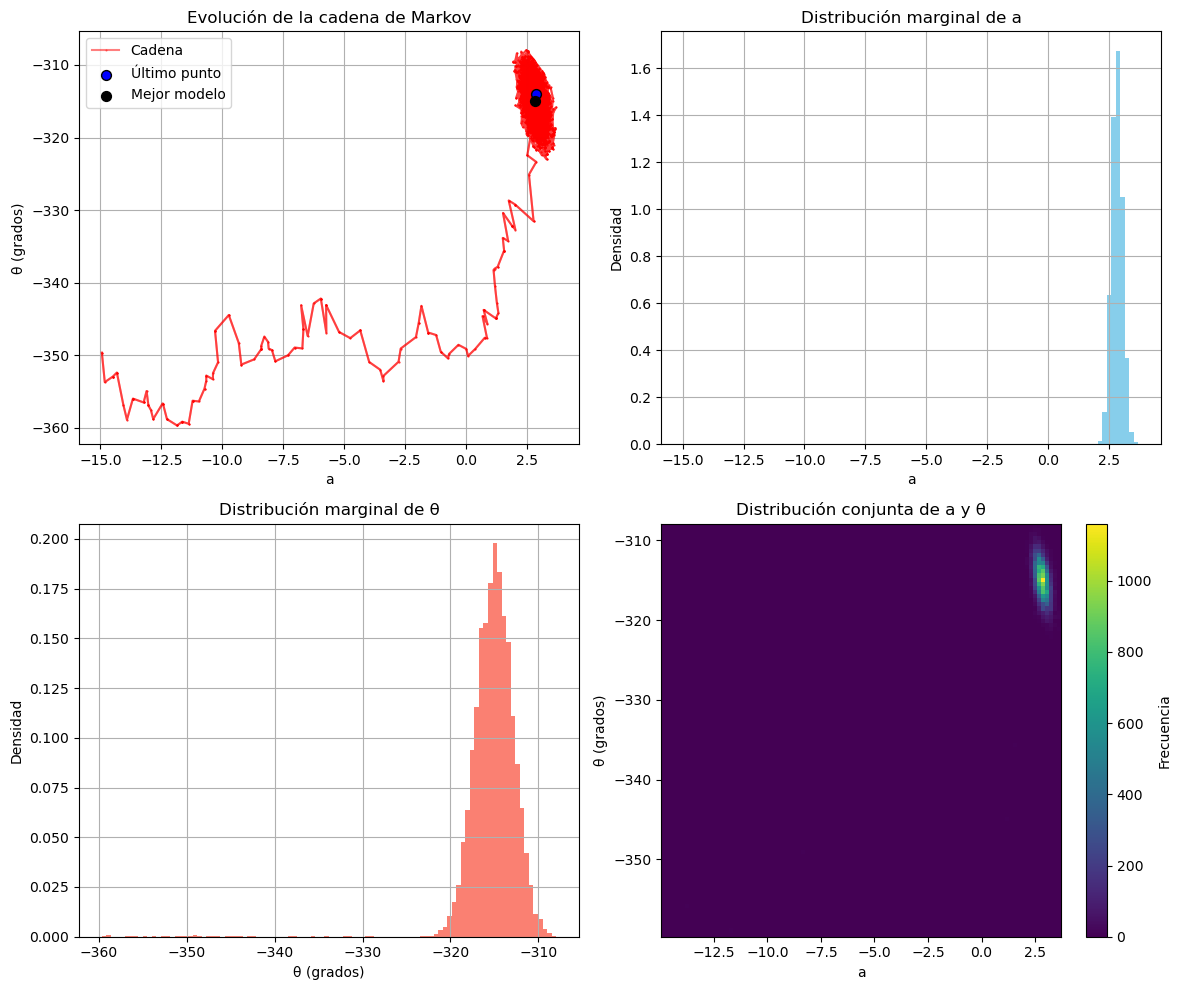

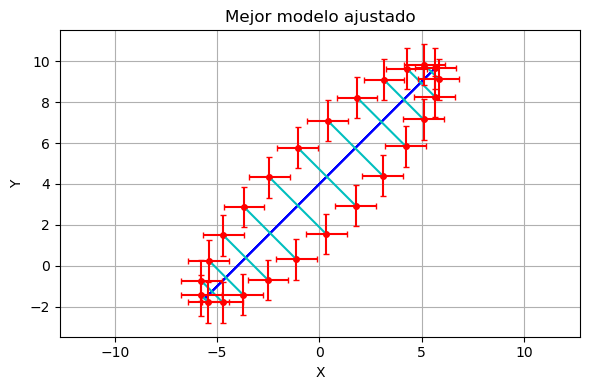

In [12]:
from GF7013.bin.Tarea2.P32.datos import obtener_datos_elipses

# === 1. Generar datos sintéticos ===
N = 25
x_obs, y_obs, sigma_x, sigma_y = obtener_datos_elipses(
    N=N,
    a=8, b=2,
    alpha=45,
    deltax=0, deltay=4,
    sigma_x=1.0, sigma_y=1.0
)

# === 2. Definir modelo directo y verosimilitud ===
modelo_forward = forward(x_obs, y_obs, sigma_x, sigma_y)

param_likelihood = {
    'mu': np.zeros(N),
    'cov': np.eye(N)
}
pdf_datos = pdf_normal(param_likelihood)

L = likelihood_function(modelo_forward, pdf_datos)

# === 3. Prior uniforme ===
prior_params = {
    'lower_lim': np.array([-15.0, -360.0]),
    'upper_lim': np.array([15.0, 360.0])
}
prior = pdf_uniform_nD(prior_params)

# === 4. Propuesta gaussiana ===
proposal = proposal_normal(cov=np.diag([0.1, 5.0]))  # ajustable

# === 5. Modelo inicial y ejecución Metropolis ===
m0 = np.array([-15.0, -350.0])  # lejos de la solución verdadera

res = metropolis(
    m0=m0,
    likelihood_fun=L,
    pdf_prior=prior,
    proposal=proposal,
    num_samples=30000,
    num_burnin=0,
    use_log_likelihood=True,
    save_samples=True,
    beta=1
)

samples = res['samples'].m_set
a_vals = samples[:, 0]
theta_vals = samples[:, 1]

# === 6. Visualización de resultados ===

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Traza de la cadena (a vs. θ)
axs[0, 0].plot(a_vals, theta_vals, '.-r', markersize=1, alpha=0.5)
axs[0, 0].set_xlabel('a')
axs[0, 0].set_ylabel('θ (grados)')
axs[0, 0].set_title('Evolución de la cadena de Markov')
axs[0, 0].grid(True)

# Histograma marginal de a
axs[0, 1].hist(a_vals, bins=100, density=True, color='skyblue')
axs[0, 1].set_xlabel('a')
axs[0, 1].set_ylabel('Densidad')
axs[0, 1].set_title('Distribución marginal de a')
axs[0, 1].grid(True)

# Histograma marginal de θ
axs[1, 0].hist(theta_vals, bins=100, density=True, color='salmon')
axs[1, 0].set_xlabel('θ (grados)')
axs[1, 0].set_ylabel('Densidad')
axs[1, 0].set_title('Distribución marginal de θ')
axs[1, 0].grid(True)

# Histograma conjunto (a, θ)
h = axs[1, 1].hist2d(a_vals, theta_vals, bins=100, cmap='viridis')
axs[1, 1].set_xlabel('a')
axs[1, 1].set_ylabel('θ (grados)')
axs[1, 1].set_title('Distribución conjunta de a y θ')
fig.colorbar(h[3], ax=axs[1, 1], label='Frecuencia')


# Traza de la cadena (a vs. θ)
axs[0, 0].plot(a_vals, theta_vals, '.-r', markersize=1, alpha=0.5, label='Cadena')
# Punto final en otro color
axs[0, 0].scatter(a_vals[-1], theta_vals[-1], color='blue', s=50, label='Último punto', edgecolors='k', zorder=5)
axs[0, 0].set_xlabel('a')
axs[0, 0].set_ylabel('θ (grados)')
axs[0, 0].set_title('Evolución de la cadena de Markov')
axs[0, 0].grid(True)



# === 7. Mostrar mejor modelo encontrado ===
i_best = np.argmax(res['samples'].f)
mejor_modelo = res['samples'].m_set[i_best, :]
print(f"\nMejor modelo encontrado: a = {mejor_modelo[0]:.2f}, θ = {mejor_modelo[1]:.2f}")
# Mejor modelo encontrado 
axs[0, 0].scatter(a_vals[i_best], theta_vals[i_best], color='black', s=50, label='Mejor modelo', edgecolors='k', zorder=5)
axs[0, 0].legend()

plt.tight_layout()
plt.show()
# Graficar mejor recta sobre los datos
fig, ax = plt.subplots(figsize=(6, 4))
dsigma_r = modelo_forward.eval(mejor_modelo)  # distancias normalizadas
m1= dsigma_r[0]
m2= dsigma_r[1]

recta.plot_recta(ax,
                 *mejor_modelo,
                 x_obs=x_obs,
                 y_obs=y_obs,
                 color_dist='c',
                 color='b')

ax.errorbar(x=x_obs, y=y_obs, xerr=sigma_x, yerr=sigma_y, fmt='.r', capsize=2)
ax.axis('equal')

ax.set_title("Mejor modelo ajustado")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.tight_layout()
plt.show()


## P4. Resolución del problema inverso: Programación del Algoritmo de Metropolis en Paralelo
En esta etapa de la tarea se programará y verificará el algoritmo de Metropolis en Paralelo. Para ello, utilizando como base el algoritmo de Metropolis recién programado, se programará una versión serial del algoritmo de Metropolis en paralelo, y por último una versión paralelizada utilizando multiprocessing.Pool.

---

## P4.1. Algoritmo de Metropolis en Paralelo (versión SERIAL)
Termine la programación de los códigos en el módulo GF7013/sampling/metropolis_in_parallel/metropolis_in_parallel_SERIAL.py.

---
En esta pregunta nos solicitan implementar la versión serial del algoritmo de Metrópolis en paralelo, siguiendo el esquema propuesto en el archivo `metropolis_in_parallel_SERIAL.py`. 

### Descripción del algoritmo

La idea principal es que cada cadena MCMC (una por cada modelo inicial) se ejecuta **de forma secuencial**, y se guarda únicamente el último modelo aceptado de cada cadena. Para ello se utiliza la función `metropolis()` previamente definida en el módulo `GF7013.sampling.metropolis.metropolis`.

La función `metropolis_in_parallel_SERIAL(...)` recibe como entrada:

- Un conjunto inicial de modelos `m0` del tipo `ensemble`.
- Las funciones de verosimilitud (`likelihood_fun`) y de probabilidad a priori (`pdf_prior`).
- El objeto `proposal`, que genera propuestas de nuevos modelos.
- El número de pasos de MCMC a ejecutar por cadena `num_MCMC_steps`.
- Un booleano `use_log_likelihood` que determina si se trabaja con valores logarítmicos o no.

Se itera sobre cada modelo inicial, ejecutando una cadena independiente con el algoritmo de Metropolis estándar. Los resultados finales (último modelo, verosimilitud, prior, posterior y tasa de aceptación) se almacenan en un nuevo `ensemble`.

El retorno de la función es:
- $m$: un nuevo objeto `ensemble` que contiene los últimos modelos de cada cadena.
- $acceptance\_ratios$: un vector con las tasas de aceptación para cada cadena.

El siguiente bloque mostrará como quedó definida la función:

```python
import numpy as NP
#import absoluto compatible con ejecución directa
from GF7013.model_parameters.ensemble import ensemble
from GF7013.sampling.metropolis.metropolis import metropolis

def metropolis_in_parallel_SERIAL(m0, likelihood_fun, pdf_prior, proposal, num_MCMC_steps,  
               use_log_likelihood = True):
    """
    Performs the Metropolis in Parallel Algorithm. THIS IS THE SERIAL VERSION OF THE 
    ALGORITHM, THUS IT RUNS ONE MCMC CHAIN AT EACH TIME.

    - m0 : initial ensemble of models for the MCMC chains.
    - likelihood_fun: an object that provides the functions likelihood_fun.likelihood(m)
                      and likelihood_fun.log_likelihood(m) that return the value or 
                      natural logarithm of the value of the likelihood function used
                      for the inverse problem.
    - pdf_prior: an object that provides the functions fprior.likelihood(m) and 
                      fprior.log_likelihood(m) that return the value or 
                      natural logarithm of the value of the prior probability
                      function on model parameters used for the inverse problem.
    - proposal: an object that provides the function proposal.propose(m) that returns
               a model m_test, proposed as the next step of the MCMC chain.
    - num_MCMC_steps: Number of MCMC steps of each Metropolis algorithm produced in 
                      parallel.
    - use_log_likelihood: if True, uses the logarithm of the likelihood of fprior and
                         of likelihood_fun to evaluate the acceptance probabilities
                         in Metropolis algorithm. Thus, needs fprior.log_likelihood(m)
                         and likelihood_fun.log_likelihood(m). If False, uses the actual
                         likelihood values, computed from fprior.likelihood(m) and 
                         likelihood_fun.likelihood(m) to evaluate acceptance probability.
    NOTE: the exponent beta of the likelihood function for TMCMC algorithm must be defined
          in the initial ensemble of models (use beta=1 if not performing TMCMC).
                          
    """
    Npar = m0.Npar
    Nmodels = m0.Nmodels
    beta = m0.beta

    # Crear un nuevo ensemble para almacenar los modelos finales
    m = ensemble(Npar=Npar, Nmodels=Nmodels, 
                use_log_likelihood=use_log_likelihood,
                beta=beta)

    # Vector para almacenar tasas de aceptación
    acceptance_ratios = NP.zeros(Nmodels)

    for i in range(Nmodels):
        modelo_inicial = m0.m_set[i, :]

        res = metropolis(
            m0=modelo_inicial,
            likelihood_fun=likelihood_fun,
            pdf_prior=pdf_prior,
            proposal=proposal,
            num_samples=num_MCMC_steps,
            num_burnin=0,  # Solo nos interesa el último modelo
            use_log_likelihood=use_log_likelihood,
            save_samples=False,  # Solo nos interesa el último modelo
            beta=beta
        )

        m.m_set[i, :] = res['m']
        m.fprior[i] = res['fprior']
        m.like[i] = res['like']
        m.f[i] = res['fpost']
        acceptance_ratios[i] = res['acceptance_ratio']

    return m, acceptance_ratios

## P4.2. Algoritmo de Metropolis en Paralelo (versión paralelizada)
Termine la programación de los códigos en el módulo GF7013/sampling/metropolis_in_parallel/metropolis_in_parallel_POOL.py (versión que comparte en multiprocessing.pool con cada chain).

---


```python
def metropolis_in_parallel_POOL(m0, likelihood_fun, pdf_prior, proposal, num_MCMC_steps,  
               use_log_likelihood = True):
    """
    Performs the Metropolis in Parallel Algorithm. THIS IS A PARALLELIZED VERSION OF THE 
    ALGORITHM, THUS IT RUNS AS MANY MCMC CHAINS AT THE SAME TIME AS THE NUMBER OF 
    COMPUTING PROCESSORS THAT ARE AVAILABLE. THIS CODE USES multiprocessing.Pool
    https://docs.python.org/3/library/multiprocessing.html

    REMEMBER TO SET THIS ENVIRONMENT VARIABLES IN THE MAIN SCRIPT OF THE CODE BEFORE
    IMPORTING ANY OTHER PACKAGE
    # set the number of threads for numpy
      import os
      os.environ["OMP_NUM_THREADS"] = "1"
      os.environ["MKL_NUM_THREADS"] = "1"
      os.environ["MKL_DOMAIN_NUM_THREADS"] = "1"
      os.environ["OPENBLAS_NUM_THREADS"] = "1"
      os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
      os.environ["NUMEXPR_NUM_THREADS"] = "1"

    - m0 : initial ensemble of models for the MCMC chains.
    - likelihood_fun: an object that provides the functions likelihood_fun.likelihood(m)
                      and likelihood_fun.log_likelihood(m) that return the value or 
                      natural logarithm of the value of the likelihood function used
                      for the inverse problem.
    - pdf_prior: an object that provides the functions fprior.likelihood(m) and 
                      fprior.log_likelihood(m) that return the value or 
                      natural logarithm of the value of the prior probability
                      function on model parameters used for the inverse problem.
    - proposal: an object that provides the function proposal.propose(m) that returns
               a model m_test, proposed as the next step of the MCMC chain.
    - num_MCMC_steps: Number of MCMC steps of each Metropolis algorithm produced in 
                      parallel.
    - use_log_likelihood: if True, uses the logarithm of the likelihood of fprior and
                         likelihood_fun to evaluate the acceptance probabilities
                         in Metropolis algorithm. Thus, needs fprior.log_likelihood(m)
                         and likelihood_fun.log_likelihood(m). If False, uses the actual
                         likelihood values, computed from fprior.likelihood(m) and 
                         likelihood_fun.likelihood(m) to evaluate acceptance probability.
                         
    NOTE:-the exponent beta of the likelihood function for TMCMC algorithm must be defined
          in the initial ensemble of models. Use beta=1 if not performing TMCMC or beta=0 
          in the initial ensemble if performing TMCMC.
         -BE careful with random number generation. Each parallel process must have a 
         different seed.                
    """

    # Number of models in the initial ensemble.
    Npar = m0.Npar
    Nmodels = m0.Nmodels

    # N burn-in iterations.
    num_burnin = num_MCMC_steps - 1
    num_samples = 1

    # Emsemble of models to be returned after the MCMC steps.
    m = ensemble(Npar, Nmodels, use_log_likelihood = use_log_likelihood)

    acceptance_ratios = NP.zeros(Nmodels)  # Acceptance ratios for each MCMC chain.
    save_samples = False  # Do not save samples in the ensemble, only the final model
    beta = m0.beta  # Use the beta value defined in the initial ensemble.
    LogOfZero = None
    rng = None
    seed = None

    # List of arguments for each MCMC chain to be run in parallel.
    args_list = [ (m0.m_set[i, :], likelihood_fun, pdf_prior, proposal, num_samples, num_burnin, use_log_likelihood, 
                    save_samples, beta, LogOfZero, rng, seed) for i in range(Nmodels)] # Lista de argumentos por cada modelo

    # Use multiprocessing.Pool to run the Metropolis algorithm in parallel.
    with Pool(processes=cpu_count()) as pool:
        
      results_pool = pool.starmap(metropolis, args_list) # Retorna una lista
    
    # Store the results in the ensemble.
    for i, result in enumerate(results_pool):
      m.m_set[i, :] = result["m"]
      m.fprior[i] = result["fprior"]
      m.like[i] = result["like"]
      m.f[i] = result["fpost"]
      acceptance_ratios[i] = result["acceptance_ratio"]
    
    return m, acceptance_ratios


## P4.3. Verificación del algoritmo
Modifique los scripts de test `tests/test_metropolis.py` en tarea2/tests/test_metropolis_in_parallel_SERIAL.py y Tarea2/tests/test_metropolis_in_parallel_POOL.py. Modifique estos últimos para que corran usando la versión serial y paralelizada respectivamente.

---

En esta sección verificamos que nuestras implementaciones de los algoritmos de Metrópolis en paralelo (versión serial y versión paralelizada) funcionan correctamente.

Para ello, utilizamos el **mismo testeo empleado previamente en el Metrópolis clásico**, el cual consiste en una distribución de verosimilitud **bimodal separada en el espacio de modelos**. Este tipo de distribución es útil para evaluar si las cadenas MCMC son capaces de explorar múltiples modos.

La distribución prior utilizada es uniforme, y las propuestas de modelos nuevos se generan mediante una distribución normal centrada en el modelo actual. 

En el caso de la implementación **serial**, se utilizan $1000$ cadenas MCMC con $1000$ pasos cada una. Esta cantidad ya es considerablemente exigente en términos computacionales, por lo que no se justifica aumentarla, especialmente cuando se compara contra la versión paralelizada (`Pool`) que se probará más adelante.

A continuación se presenta el código de testeo aplicado a la versión serial:


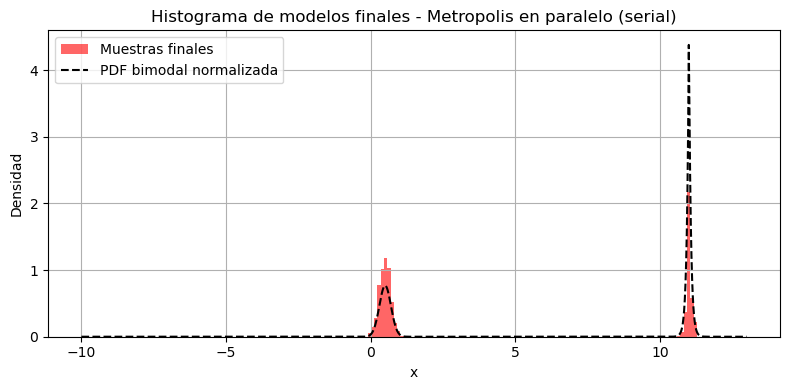

Tasa de aceptación promedio: 0.242366


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# === Importar funciones desde la estructura GF7013 ===
from GF7013.sampling.metropolis_in_parallel.metropolis_in_parallel_SERIAL import metropolis_in_parallel_SERIAL
from GF7013.model_parameters.ensemble import ensemble
from GF7013.sampling.metropolis.proposal_normal import proposal_normal
from GF7013.probability_functions.pdf.pdf_uniform_nD import pdf_uniform_nD

# === Definición de PDF bimodal ===
class pdf_bimodal:
    def __init__(self, x_0, sigma_0, p_0, x_1, sigma_1, p_1):
        self.args_f0 = (x_0, sigma_0, p_0)
        self.args_f1 = (x_1, sigma_1, p_1)

    def __f(self, x, mean, sigma, p):
        alpha = 1 / sigma / np.sqrt(2 * np.pi)
        return alpha * np.exp(-0.5 * np.abs((x - mean) / sigma) ** p)

    def likelihood(self, x):
        return self.__f(x, *self.args_f0) + self.__f(x, *self.args_f1)

    def log_likelihood(self, x):
        like = self.likelihood(x)
        return -1e10 if like <= 0 else np.log(like)

# === Crear PDF bimodal sintética ===
f = pdf_bimodal(x_0=0.5, sigma_0=0.2, p_0=2,
                x_1=11, sigma_1=0.0335, p_1=1)

# === Prior uniforme entre -10 y 13 ===
lower = np.array([-10.0])
upper = np.array([13.0])
prior_pars = {"lower_lim": lower, "upper_lim": upper}
prior = pdf_uniform_nD(par=prior_pars)

# === Proposal normal ===
sigma_prop = (upper[0] - lower[0]) / 30
cov = np.array([[sigma_prop ** 2]])
proposal = proposal_normal(cov=cov)

# === Ensemble inicial ===
Nchains = 1000
rng = np.random.default_rng(seed=42)

m0 = ensemble(Npar=1, Nmodels=Nchains, use_log_likelihood=True, beta=1)
for i in range(Nchains): # hacemos el mismo numero de modelos que el largo de las cadenas
    m0.m_set[i, :] = rng.uniform(low=lower[0], high=upper[0], size=1)
# === Ejecutar Metropolis en paralelo (serial version) ===
m, tasas = metropolis_in_parallel_SERIAL(
    m0=m0,
    likelihood_fun=f,
    pdf_prior=prior,
    proposal=proposal,
    num_MCMC_steps=1000,
    num_burnin=0,  # No burn-in en este caso
    use_log_likelihood=True
)

# === Visualización de los modelos finales ===
plt.figure(figsize=(8, 4))
plt.hist(m.m_set[:, 0], bins=100, density=True, color='red', alpha=0.6, label='Muestras finales')
x = np.linspace(-10, 13, 1000)
f_vals = np.array([f.likelihood(xi) for xi in x])
f_vals /= np.trapz(f_vals, x)
plt.plot(x, f_vals, 'k--', label='PDF bimodal normalizada')
plt.title('Histograma de modelos finales - Metropolis en paralelo (serial)')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar tasas
print("Tasa de aceptación promedio:", np.mean(tasas))


Mientras que para la versión pool, es necesario llamar al código directamente

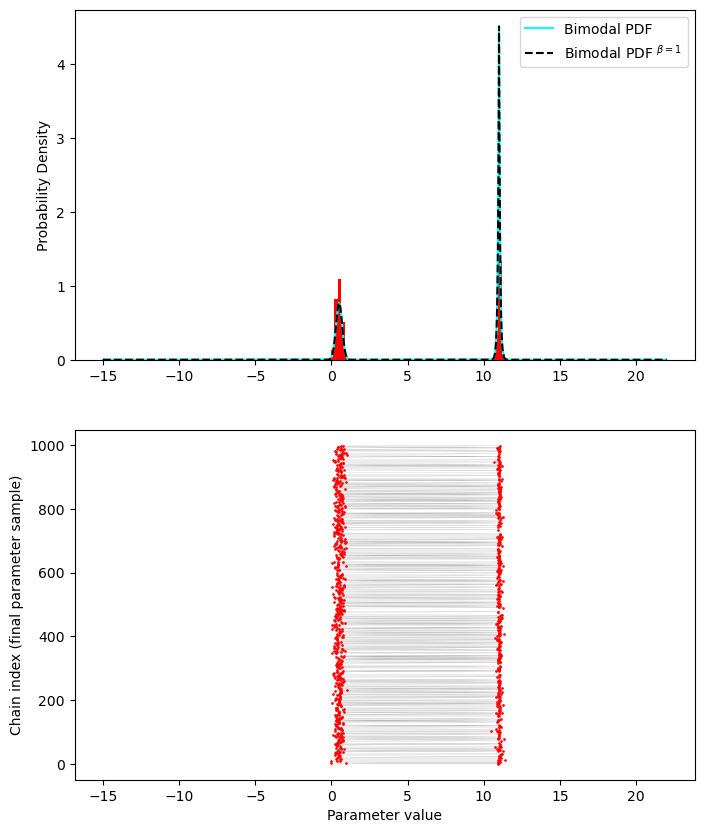

In [14]:
ruta_script_parapool = os.path.abspath(os.path.join(os.getcwd(), 'tests/test_metropolis_paralelo_POOL.py'))
%run $ruta_script_parapool


## P4.4. Aplicación al Problema de Ajuste Ortogonal a la Recta
Repita los pasos en P3.2, pero esta vez programando con modelos iniciales generados como muestras de propuestas. Desarrolle esta parte de la tarea en el carpeta Tarea2/P4.
---

In [20]:
from GF7013.bin.Tarea2.P1.datos import obtener_datos_elipses
from GF7013.sampling.metropolis_in_parallel.metropolis_in_parallel_POOL import metropolis_in_parallel_POOL

N = 25
semi_eje_mayor = 8
semi_eje_menor = 2
alpha = 45
delta_x = 0
delta_y = 4
desviacion_estandar_x = 1.0
desviacion_estandar_y = 1.0

x_obs, y_obs, sigma_x, sigma_y = obtener_datos_elipses(
                                        N = N,
                                        a = semi_eje_mayor,
                                        b = semi_eje_menor,
                                        alpha = alpha,
                                        deltax = delta_x,
                                        deltay = delta_y,
                                        sigma_x = desviacion_estandar_x,
                                        sigma_y = desviacion_estandar_y)

min_a, max_a = -15, 15

min_theta, max_theta = -360, 360

par = {}
par['lower_lim'] = np.array([min_a, min_theta])
par['upper_lim'] = np.array([max_a, max_theta])
LogOfZero = None
rng = np.random.default_rng(888)
fprior = pdf_uniform_nD(par = par, LogOfZero=LogOfZero, rng=rng)

# Modelo forward
forward_model = forward(x_obs, y_obs, sigma_x, sigma_y)

# Likelihood function
mu = np.zeros(N)
cov = np.eye(N) # matriz identidad
par = {'mu': mu, 'cov': cov}

f = likelihood_function(forward_model, pdf_normal(par=par, rng=rng))

# Distribution de proposición
sigma_prop_a = (max_a - min_a) / 100
sigma_prop_theta = (max_theta - min_theta) / 100
proposal_params = {}
proposal_params['cov'] = np.array([[sigma_prop_a, 0], [0, sigma_prop_theta]])  # matriz de covarianza 2D
proposal_pdf = proposal_normal(proposal_params['cov'])

# Modelos iniciales aleatorios provenientes de fprior
Npar = int(len(fprior.par['lower_lim']))  # número de parámetros del modelo
Nmodelos = int(1e4)
modelos_iniciales = fprior._draw(Ns = Nmodelos)

a_samples = modelos_iniciales[0]
theta_samples = modelos_iniciales[1]

modelos_iniciales_reshape = np.zeros((Nmodelos, Npar))
for i in range(Nmodelos):
    modelos_iniciales_reshape[i, :] = [a_samples[i], theta_samples[i]]

# Ensamble de modelos iniciales
m0 = ensemble(Npar, Nmodelos, use_log_likelihood=True)
m0.m_set = modelos_iniciales_reshape  # set the initial models in the ensemble

# Número de pasos MCMC
num_MCMC_steps = int(1E2)
use_log_likelihood = True

# Se utilizará el algortimo de Metropolis en paralelo en paralelo
# para resolver el problema de ajuste de la recta a los datos
m, acceptance_ratios = metropolis_in_parallel_POOL(m0 = m0,
            likelihood_fun = f, 
            pdf_prior = fprior,
            proposal = proposal_pdf, 
            num_MCMC_steps = num_MCMC_steps,
            use_log_likelihood = use_log_likelihood)



Se procede a realizar una figura con el m final de cada una de las cadenas, mapas de distribución, los histogramas marginales y cómo es que queda la solución utilizando los parámetros del máximo likelihood

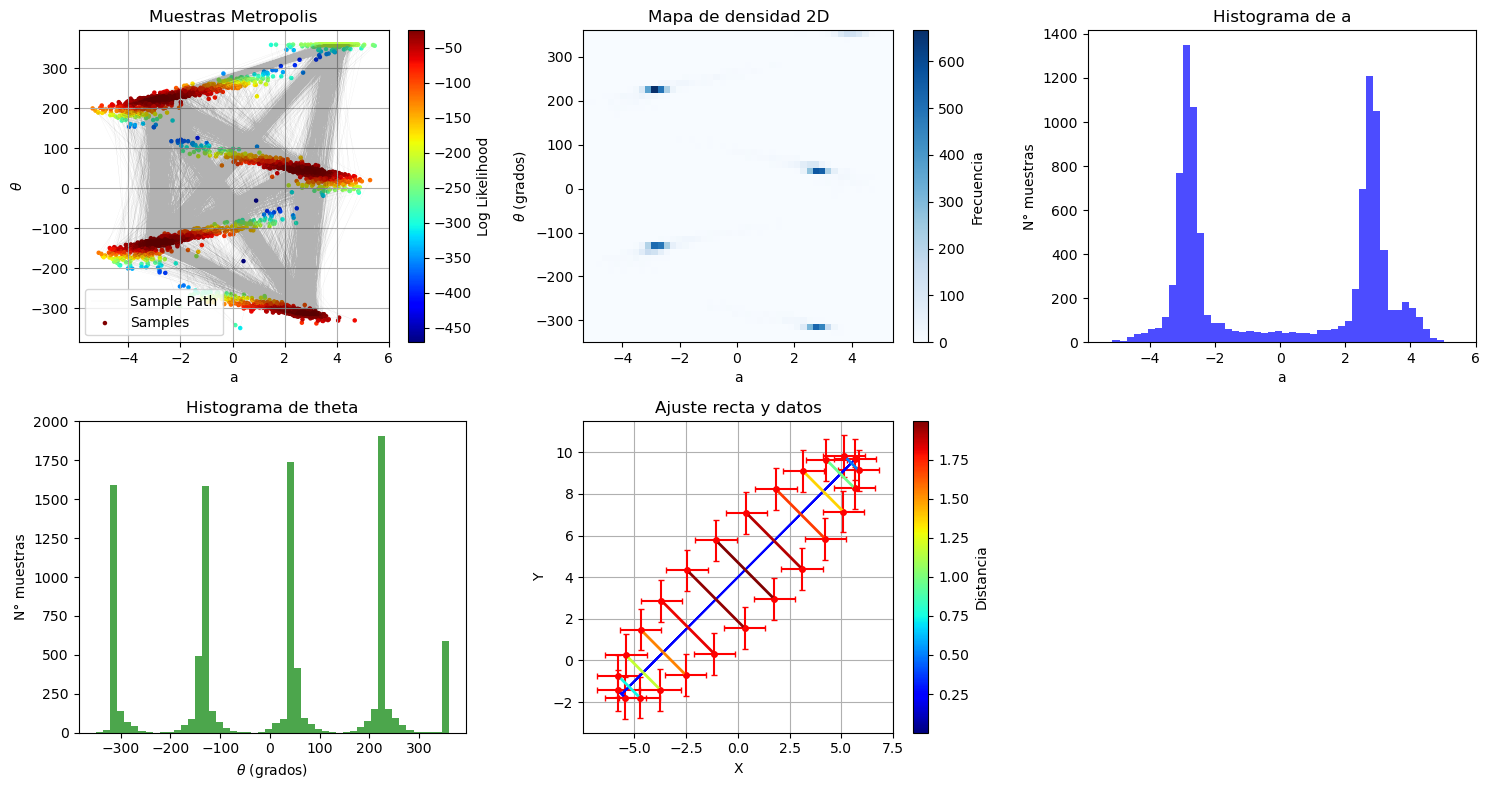

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from GF7013.models.ajuste_ortogonal_recta.recta import calc_xy_pred

fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# 1) Caminata con línea y puntos coloreados por log likelihood
axs[0, 0].plot(m.m_set[:, 0], m.m_set[:, 1], 'k-', lw=0.05, alpha=0.3, label='Sample Path')
sc = axs[0, 0].scatter(m.m_set[:, 0], m.m_set[:, 1], s=5, c=m.f, cmap='jet', label='Samples')
axs[0, 0].set(xlabel='a', ylabel=r'$\theta$', title='Muestras Metropolis')
axs[0, 0].grid(True)
fig.colorbar(sc, ax=axs[0, 0], label='Log Likelihood')
axs[0, 0].legend(loc='lower left')

# 2) Histograma 2D
H, xedges, yedges = np.histogram2d(m.m_set[:, 0], m.m_set[:, 1], bins=50)
# Pcolormesh usa los bordes de los bins para hacer la malla
X, Y = np.meshgrid(xedges, yedges)
# Graficar con pcolormesh
pcm = axs[0, 1].pcolormesh(X, Y, H.T, cmap='Blues', shading='auto', alpha=1)
#
axs[0, 1].set(xlabel='a', ylabel=r'$\theta$ (grados)', title='Mapa de densidad 2D')
fig.colorbar(pcm, ax=axs[0, 1], label='Frecuencia')

# 3) Histograma univariado de 'a'
axs[0, 2].hist(m.m_set[:, 0], bins=50, alpha=0.7, color='blue')
axs[0, 2].set(xlabel='a', ylabel='N° muestras', title='Histograma de a')

# 4) Histograma univariado de 'theta'
axs[1, 0].hist(m.m_set[:, 1], bins=50, alpha=0.7, color='green')
axs[1, 0].set(xlabel=r'$\theta$ (grados)', ylabel='N° muestras', title='Histograma de theta')

# 5) Ajuste recta y líneas de distancia coloreadas
max_index = np.argmax(m.f)
a, theta = m.m_set[max_index]
m_plot = np.array([a, theta])
axs[1, 1].errorbar(x_obs, y_obs, xerr=sigma_x, yerr=sigma_y, fmt='.r', capsize=2)

recta.plot_recta(axs[1, 1], *m_plot, x_obs=x_obs, y_obs=y_obs, color='b', color_dist=None)
x_pred, y_pred, _ = calc_xy_pred(*m_plot, x_obs, y_obs)
distancias = np.linalg.norm(np.column_stack((x_pred - x_obs, y_pred - y_obs)), axis=1)
segments = [[(x_pred[i], y_pred[i]), (x_obs[i], y_obs[i])] for i in range(len(x_pred))]
lc = LineCollection(segments, cmap='jet', linewidths=2, alpha=1)
lc.set_array(distancias)
axs[1, 1].add_collection(lc)
axs[1, 1].set_title('Ajuste recta y datos')
cbar = fig.colorbar(lc, ax=axs[1, 1])
cbar.set_label('Distancia')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
axs[1, 1].grid(True)
# 6) Eliminar último subplot sobrante
fig.delaxes(axs[1, 2])

plt.tight_layout()
# plt.savefig('resumen_metropolis.png', dpi=300)
plt.show()
